In [2]:
from surprise import Dataset, Reader
from surprise import dump
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import accuracy, Dataset, SVD, KNNBasic, KNNWithMeans, KNNWithZScore,Prediction,SlopeOne
from surprise.model_selection import GridSearchCV
from surprise import Prediction
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import time

In [3]:
svd=dump.load('modelli_Allenati/SVD')[1]
knnB_user=dump.load('modelli_Allenati/KnnBase_u')[1]
knnB_item=dump.load('modelli_Allenati/KnnBase_i')[1]
knnM_user=dump.load('modelli_Allenati/algo_KnnMeans_u')[1]
knnM_item=dump.load('modelli_Allenati/algo_KnnMeans_i')[1]
knnB_ibrido=dump.load('modelli_Allenati/algo_KnnBase_ibrido')[1]
knnM_ibrido=dump.load('modelli_Allenati/algo_KnnMeans_ibrido')[1]
slope=dump.load('modelli_Allenati/slopeOne')[1]

In [4]:
#prendo i dati
data = Dataset.load_builtin("ml-1m")
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [5]:
#leggo i dataset contenenti i film con relativi id,nomi e generi
movies_df = pd.read_csv('dataset/ml-1m/movies.dat',
                        delimiter='::', engine= 'python', header=None,
                        names=['movie_id','movie_name', 'genre'], encoding='latin-1')
movies_df.head()

#creo un dizionario che collega gli id dei film ai relativi titoli

idToName = movies_df.set_index('movie_id').transpose().to_dict(orient='dict')

In [6]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [7]:
#stampa la lista dei film consigliati
def mostraListaConsigliati(idUtente,top,idToName):
    """prints the list top-N recommendation for a user from a set of predictions.

    Args:
        idUtente(string): the id of the user.
        n(dict): dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
        idToName: dict where keys are movie (raw) ids and values are the movies name

    Returns:
        Nothing
    """
    i=1
    for x in top[idUtente]:
        print(i,' Titolo:', idToName.get(int(x[0]))["movie_name"], 'ratingStimato', x[1])
        i=i+1

In [8]:
#funzione che riporta le predizioni del modello ibrido nello stesso formato degli altri
def predictIbrido(algo_ibrido,algo_user,algo_item,set):
     """returns the predictions for thy hybrid model based on those
        made by the user-based and item-based models.

    Args:
        algo_KnnBase_ibrido(string): the trained hybrid model to use.
        algo_user: the trained model for user-based predictions to use.
        algo_item: the trained model for user-based predictions to use.
        set: the set of ratings to predict

    Returns:
        list of Prediction objects
    """
     predictions1 = algo_user.test(set)
     predictions2 = algo_item.test(set)
     X=[]
     y=[]
     for i in range(len(predictions1)):
        X.append([predictions1[i][3],predictions2[i][3]])
        y.append(predictions1[i][2])
    
     algo_ibrido.score(X, y)
     predictionsIbride=algo_ibrido.predict(X)
     predFinali=[]
     for i in range(len(predictions1)):
        predFinali.append(Prediction(predictions1[i].uid, predictions1[i].iid, predictions1[i].r_ui, predictionsIbride[i], predictions1[i].details))
     return predFinali

#funzione modificata in cui le predizioni per gli user-based e itembased sono gia state calcolate
def predictIbrido2(algo_ibrido,pred_user,pred_item,set):
     """returns the predictions for thy hybrid model based on those
        made by the user-based and item-based models.

    Args:
        algo_KnnBase_ibrido(string): the trained hybrid model to use.
        algo_user: the trained model for user-based predictions to use.
        algo_item: the trained model for user-based predictions to use.
        set: the set of ratings to predict

    Returns:
        list of Prediction objects
    """
     predictions1 = pred_user
     predictions2 = pred_item
     X=[]
     y=[]
     for i in range(len(predictions1)):
        X.append([predictions1[i][3],predictions2[i][3]])
    
     predictionsIbride=algo_ibrido.predict(X)
     predFinali=[]
     for i in range(len(predictions1)):
        predFinali.append(Prediction(predictions1[i].uid, predictions1[i].iid, predictions1[i].r_ui, predictionsIbride[i], predictions1[i].details))
     return predFinali

In [9]:
#dizionario dei tempi di predizione impiegati da tutti i modelli
tempi={}

In [9]:

#calcolo le predizioni usando svd per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predSvd=svd.test(testset)
tempi["svd"]=time.time()-start_time


In [11]:
consigliSVD=get_top_n(predSvd,10)
mostraListaConsigliati("1",consigliSVD,idToName)

1  Titolo: Sanjuro (1962) ratingStimato 4.807156753199105
2  Titolo: Children of Heaven, The (Bacheha-Ye Aseman) (1997) ratingStimato 4.767202960177623
3  Titolo: Shawshank Redemption, The (1994) ratingStimato 4.7195965288082515
4  Titolo: Rear Window (1954) ratingStimato 4.710407731067662
5  Titolo: It Happened One Night (1934) ratingStimato 4.621547667312651
6  Titolo: It's a Wonderful Life (1946) ratingStimato 4.612066166362609
7  Titolo: Apple, The (Sib) (1998) ratingStimato 4.607319943891387
8  Titolo: Double Indemnity (1944) ratingStimato 4.597454302028744
9  Titolo: Great Escape, The (1963) ratingStimato 4.591395742157781
10  Titolo: Raiders of the Lost Ark (1981) ratingStimato 4.574652225138766


In [12]:
#calcolo le predizioni usando SlopeOne per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predSlope=slope.test(testset)
tempi["SlopeOne"]=time.time()-start_time


In [18]:
consigliSlope=get_top_n(predSlope,10)
mostraListaConsigliati("1",consigliSlope,idToName)

1  Titolo: For All Mankind (1989) ratingStimato 5
2  Titolo: Gate of Heavenly Peace, The (1995) ratingStimato 5
3  Titolo: I Am Cuba (Soy Cuba/Ya Kuba) (1964) ratingStimato 5
4  Titolo: Hour of the Pig, The (1993) ratingStimato 5
5  Titolo: Soft Fruit (1999) ratingStimato 5
6  Titolo: Institute Benjamenta, or This Dream People Call Human Life (1995) ratingStimato 5
7  Titolo: Lamerica (1994) ratingStimato 5
8  Titolo: Paralyzing Fear: The Story of Polio in America, A (1998) ratingStimato 5
9  Titolo: Message to Love: The Isle of Wight Festival (1996) ratingStimato 5
10  Titolo: Mamma Roma (1962) ratingStimato 5


In [15]:
#calcolo le predizioni usando knn base user-based per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnBu=knnB_user.test(testset)
tempi["KnnBaseUser"]=time.time()-start_time


In [19]:
consigliKnnBu=get_top_n(predKnnBu,10)
mostraListaConsigliati("1",consigliKnnBu,idToName)

1  Titolo: Gate of Heavenly Peace, The (1995) ratingStimato 5
2  Titolo: Seven Chances (1925) ratingStimato 5
3  Titolo: Vampyros Lesbos (Las Vampiras) (1970) ratingStimato 5
4  Titolo: Paralyzing Fear: The Story of Polio in America, A (1998) ratingStimato 5
5  Titolo: Follow the Bitch (1998) ratingStimato 5
6  Titolo: Smashing Time (1967) ratingStimato 5
7  Titolo: Ulysses (Ulisse) (1954) ratingStimato 5
8  Titolo: Song of Freedom (1936) ratingStimato 5
9  Titolo: Modulations (1998) ratingStimato 5
10  Titolo: One Little Indian (1973) ratingStimato 5


In [20]:
#calcolo le predizioni usando knn base item-based per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnBi=knnB_item.test(testset)
tempi["KnnBaseitem"]=time.time()-start_time

In [22]:
consigliKnnBi=get_top_n(predKnnBi,10)
mostraListaConsigliati("1",consigliKnnBi,idToName)

1  Titolo: Loves of Carmen, The (1948) ratingStimato 5
2  Titolo: Smoking/No Smoking (1993) ratingStimato 5
3  Titolo: Low Life, The (1994) ratingStimato 4.949238578680203
4  Titolo: Promise, The (Versprechen, Das) (1994) ratingStimato 4.909090909090909
5  Titolo: Jar, The (Khomreh) (1992) ratingStimato 4.6875
6  Titolo: Modulations (1998) ratingStimato 4.6717892425905605
7  Titolo: Back Stage (2000) ratingStimato 4.666666666666667
8  Titolo: White Boys (1999) ratingStimato 4.666666666666667
9  Titolo: Venice/Venice (1992) ratingStimato 4.602564102564104
10  Titolo: Waltzes from Vienna (1933) ratingStimato 4.579227696404794


In [10]:
#calcolo le predizioni usando knn Means user-based per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnMu=knnM_user.test(testset)
tempi["KnnMeansUser"]=time.time()-start_time

In [14]:
consigliKnnMu=get_top_n(predKnnMu,10)
mostraListaConsigliati("1",consigliKnnMu,idToName)

1  Titolo: Silence of the Lambs, The (1991) ratingStimato 5
2  Titolo: Shawshank Redemption, The (1994) ratingStimato 5
3  Titolo: Seven (Se7en) (1995) ratingStimato 5
4  Titolo: For All Mankind (1989) ratingStimato 5
5  Titolo: Chushingura (1962) ratingStimato 5
6  Titolo: Gate of Heavenly Peace, The (1995) ratingStimato 5
7  Titolo: Sanjuro (1962) ratingStimato 5
8  Titolo: I Am Cuba (Soy Cuba/Ya Kuba) (1964) ratingStimato 5
9  Titolo: Man of the Century (1999) ratingStimato 5
10  Titolo: Hour of the Pig, The (1993) ratingStimato 5


In [15]:
#calcolo le predizioni usando knn Means item-based per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnMi=knnM_item.test(testset)
tempi["KnnMeansItem"]=time.time()-start_time

In [17]:
consigliKnnMi=get_top_n(predKnnMi,10)
mostraListaConsigliati("1",consigliKnnMi,idToName)

1  Titolo: Baby, The (1973) ratingStimato 5
2  Titolo: Seven Chances (1925) ratingStimato 5
3  Titolo: Apple, The (Sib) (1998) ratingStimato 5
4  Titolo: Paralyzing Fear: The Story of Polio in America, A (1998) ratingStimato 5
5  Titolo: Follow the Bitch (1998) ratingStimato 5
6  Titolo: Smashing Time (1967) ratingStimato 5
7  Titolo: Song of Freedom (1936) ratingStimato 5
8  Titolo: Modulations (1998) ratingStimato 5
9  Titolo: Firelight (1997) ratingStimato 4.994799778656341
10  Titolo: One Little Indian (1973) ratingStimato 4.987127623907103


In [ ]:
#calcolo le predizioni usando knn base ibrido per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnBibrido=predictIbrido2(knnB_ibrido,predKnnBu,predKnnBi,testset)
tempi["KnnBaseIbrido"]=time.time()-start_time

In [ ]:
consigliKnnBibrido=get_top_n(predKnnBibrido,10)
mostraListaConsigliati("1",consigliKnnBibrido,idToName)

In [18]:
#calcolo le predizioni usando knn Means ibrido per tutte le coppie (u,i) per cui non esiste rating e verifico quanto tempo impiega il sistema
start_time = time.time()
predKnnMibrido=predictIbrido2(knnM_ibrido,predKnnMu,predKnnMi,testset)
tempi["KnnMeansIbrido"]=time.time()-start_time

In [35]:
consigliKnnMibrido=get_top_n(predKnnMibrido,10)
mostraListaConsigliati("1",consigliKnnMibrido,idToName)

1  Titolo: Seven Chances (1925) ratingStimato 5.299113869856971
2  Titolo: Apple, The (Sib) (1998) ratingStimato 5.299113869856971
3  Titolo: Paralyzing Fear: The Story of Polio in America, A (1998) ratingStimato 5.299113869856971
4  Titolo: Follow the Bitch (1998) ratingStimato 5.299113869856971
5  Titolo: Smashing Time (1967) ratingStimato 5.299113869856971
6  Titolo: Song of Freedom (1936) ratingStimato 5.299113869856971
7  Titolo: Modulations (1998) ratingStimato 5.299113869856971
8  Titolo: Firelight (1997) ratingStimato 5.296968690134397
9  Titolo: One Little Indian (1973) ratingStimato 5.293803795852238
10  Titolo: Gate of Heavenly Peace, The (1995) ratingStimato 5.286083419439313


In [27]:
tempi

{'svd': 118.53236961364746,
 'SlopeOne': 1119.0508766174316,
 'KnnBaseUser': 2284.8402156829834,
 'KnnBaseitem': 1843.184753894806,
 'KnnMeansUser': 2166.1079556941986,
 'KnnMeansItem': 1720.1373143196106,
 'KnnMeansIbrido': 3977.09072971344,
 'KnnBaseIbrido': 4218.87042927742}

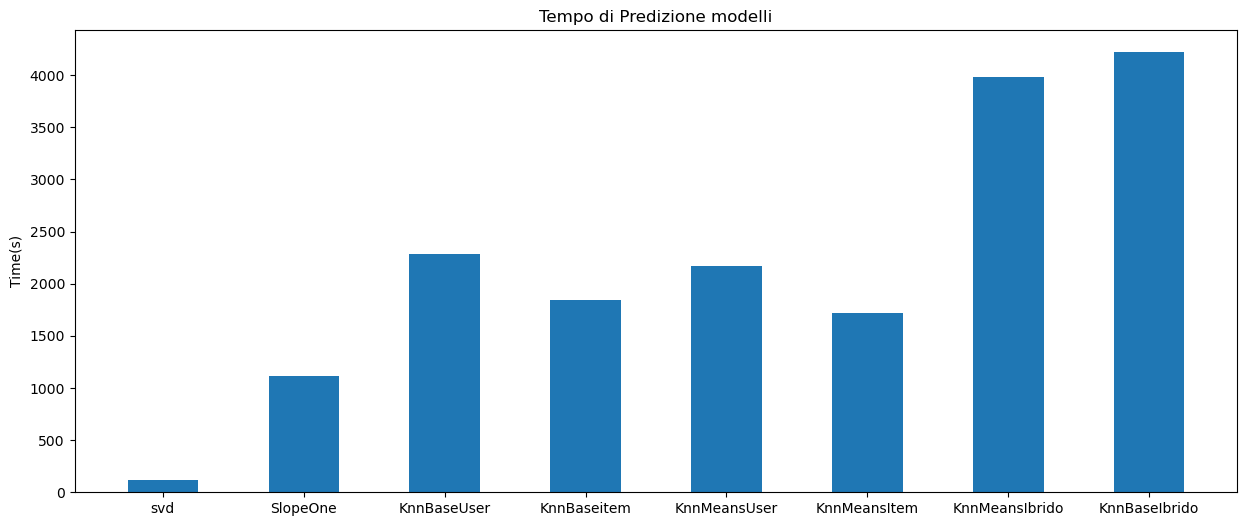

In [34]:
plt.figure(figsize=(15,6))
plt.title('Tempo di Predizione modelli')
plt.bar(tempi.keys(),tempi.values(),width=0.5)
plt.ylabel('Time(s)')
plt.savefig('img\Prediction_time.jpg')